# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

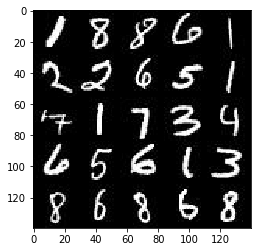

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

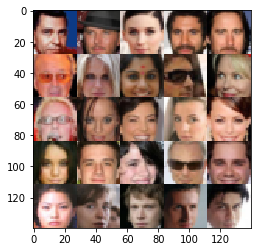

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(x3, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)
        # 4x4x512
        
        flat = tf.reshape(x4, [-1, 4*4*512])        
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x128

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(seed=42))
        output = tf.tanh(logits)
        # 28x28xout_channel_dim

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        #d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        #g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.RMSPropOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
def plot_losses(d_loss, g_loss):
    fig, ax = pyplot.subplots()
    pyplot.plot(d_loss, label='Discriminator', alpha=0.5)
    pyplot.plot(g_loss, label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3 if data_image_mode == 'RGB' else 1
    
    print(data_shape)
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    loss_d, loss_g = [], []
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        last = time.perf_counter()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                step += 1
                
                if step % 10 == 0:
                    now = time.perf_counter()
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    train_loss_d = sess.run(d_loss, feed_dict={input_z: batch_z, input_real: batch_images})
                    loss_d.append(train_loss_d)
                    loss_g.append(train_loss_g)
                    print("Epoch {}/{}... Elapsed {:.2f} seconds,".format(epoch_i+1, epoch_count, now-last),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    last = now
                
                if step % 200 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

        print("Final Output:")
        show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        plot_losses(loss_d, loss_g)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/4... Elapsed 3.18 seconds, Discriminator Loss: 1.0819... Generator Loss: 0.9398
Epoch 1/4... Elapsed 2.52 seconds, Discriminator Loss: 0.8271... Generator Loss: 1.3118
Epoch 1/4... Elapsed 2.26 seconds, Discriminator Loss: 0.8466... Generator Loss: 1.2486
Epoch 1/4... Elapsed 2.28 seconds, Discriminator Loss: 2.5559... Generator Loss: 0.1538
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 3.2210... Generator Loss: 0.0869
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 3.2750... Generator Loss: 0.0792
Epoch 1/4... Elapsed 2.29 seconds, Discriminator Loss: 6.4354... Generator Loss: 0.0050
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 3.4392... Generator Loss: 0.0743
Epoch 1/4... Elapsed 2.29 seconds, Discriminator Loss: 3.1322... Generator Loss: 0.0931
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 3.4612... Generator Loss: 0.0921
Epoch 1/4... Elapsed 2.29 seconds, Discriminator Loss: 3.1560... Generator Loss: 0.1003
Epoch 1/4... 

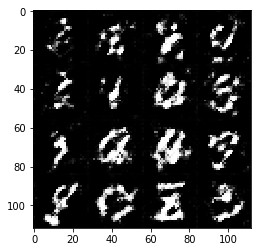

Epoch 1/4... Elapsed 2.59 seconds, Discriminator Loss: 1.7207... Generator Loss: 0.5543
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 2.2149... Generator Loss: 0.3111
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 2.1467... Generator Loss: 0.3347
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.8748... Generator Loss: 1.0928
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 2.9368... Generator Loss: 0.2028
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.1169... Generator Loss: 1.0474
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.3156... Generator Loss: 0.7216
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.9234... Generator Loss: 0.3427
Epoch 1/4... Elapsed 2.30 seconds, Discriminator Loss: 1.5867... Generator Loss: 0.5027
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.8036... Generator Loss: 0.4268
Epoch 1/4... Elapsed 2.31 seconds, Discriminator Loss: 0.4152... Generator Loss: 2.7377
Epoch 1/4... Elapsed 2.32 second

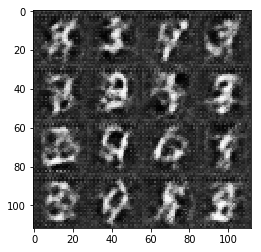

Epoch 1/4... Elapsed 2.62 seconds, Discriminator Loss: 0.3622... Generator Loss: 5.1358
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.4649... Generator Loss: 0.6943
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4136... Generator Loss: 3.0145
Epoch 1/4... Elapsed 2.31 seconds, Discriminator Loss: 0.3724... Generator Loss: 3.6531
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.0449... Generator Loss: 2.8602
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4430... Generator Loss: 2.4524
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 3.2691... Generator Loss: 0.0981
Epoch 1/4... Elapsed 2.31 seconds, Discriminator Loss: 0.3579... Generator Loss: 4.5274
Epoch 1/4... Elapsed 2.31 seconds, Discriminator Loss: 0.3521... Generator Loss: 6.7325
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.2621... Generator Loss: 2.9018
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3820... Generator Loss: 3.6258
Epoch 1/4... Elapsed 2.32 second

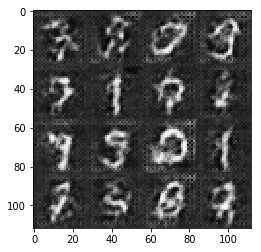

Epoch 1/4... Elapsed 2.70 seconds, Discriminator Loss: 0.3544... Generator Loss: 4.2049
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3940... Generator Loss: 3.4303
Epoch 1/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3395... Generator Loss: 5.1698
Epoch 1/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3574... Generator Loss: 7.2855
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.4892... Generator Loss: 8.0972
Epoch 1/4... Elapsed 2.33 seconds, Discriminator Loss: 0.4182... Generator Loss: 2.7659
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3761... Generator Loss: 6.0550
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4032... Generator Loss: 3.7377
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.5438... Generator Loss: 2.0131
Epoch 1/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3630... Generator Loss: 5.1483
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3373... Generator Loss: 6.6483
Epoch 1/4... Elapsed 2.32 second

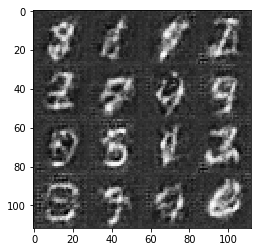

Epoch 1/4... Elapsed 2.62 seconds, Discriminator Loss: 0.3466... Generator Loss: 4.6246
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 1.5033... Generator Loss: 0.8880
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.6362... Generator Loss: 1.6001
Epoch 1/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4557... Generator Loss: 2.3472
Epoch 1/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3933... Generator Loss: 7.8543
Epoch 1/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3413... Generator Loss: 6.2043
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4207... Generator Loss: 4.4869
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4135... Generator Loss: 5.4704
Epoch 1/4... Elapsed 2.34 seconds, Discriminator Loss: 1.4792... Generator Loss: 0.9475
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3998... Generator Loss: 2.8667
Epoch 1/4... Elapsed 2.32 seconds, Discriminator Loss: 0.5124... Generator Loss: 2.0576
Epoch 1/4... Elapsed 2.32 second

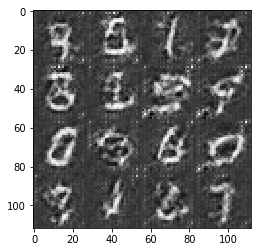

Epoch 2/4... Elapsed 2.62 seconds, Discriminator Loss: 0.4414... Generator Loss: 3.5537
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3566... Generator Loss: 4.0734
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3541... Generator Loss: 7.2080
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.8142... Generator Loss: 2.8962
Epoch 2/4... Elapsed 2.33 seconds, Discriminator Loss: 0.4353... Generator Loss: 6.9411
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.8398... Generator Loss: 9.2524
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4361... Generator Loss: 2.6218
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3304... Generator Loss: 8.2269
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3530... Generator Loss: 8.2376
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3434... Generator Loss: 5.4252
Epoch 2/4... Elapsed 2.33 seconds, Discriminator Loss: 0.5244... Generator Loss: 2.0141
Epoch 2/4... Elapsed 2.34 second

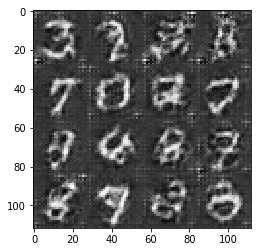

Epoch 2/4... Elapsed 2.61 seconds, Discriminator Loss: 0.3974... Generator Loss: 9.0185
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4609... Generator Loss: 3.5122
Epoch 2/4... Elapsed 2.31 seconds, Discriminator Loss: 5.1278... Generator Loss: 0.0166
Epoch 2/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3392... Generator Loss: 5.2895
Epoch 2/4... Elapsed 2.35 seconds, Discriminator Loss: 0.4131... Generator Loss: 4.8411
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3832... Generator Loss: 3.7410
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3608... Generator Loss: 3.9294
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3556... Generator Loss: 5.3086
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4049... Generator Loss: 5.2775
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 1.3326... Generator Loss: 0.6881
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3437... Generator Loss: 5.0386
Epoch 2/4... Elapsed 2.34 second

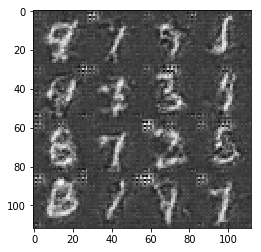

Epoch 2/4... Elapsed 2.62 seconds, Discriminator Loss: 0.5430... Generator Loss: 2.0801
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3414... Generator Loss: 4.9161
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3451... Generator Loss: 6.8472
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 1.6298... Generator Loss: 5.6859
Epoch 2/4... Elapsed 2.31 seconds, Discriminator Loss: 0.3523... Generator Loss: 4.3888
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3951... Generator Loss: 3.1469
Epoch 2/4... Elapsed 2.33 seconds, Discriminator Loss: 0.5987... Generator Loss: 3.1853
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.5702... Generator Loss: 8.2017
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3372... Generator Loss: 5.6566
Epoch 2/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3280... Generator Loss: 9.0604
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4265... Generator Loss: 4.1869
Epoch 2/4... Elapsed 2.33 second

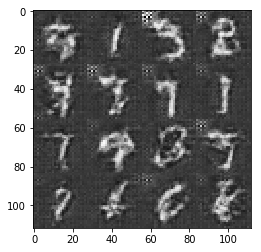

Epoch 2/4... Elapsed 2.62 seconds, Discriminator Loss: 0.3322... Generator Loss: 6.8203
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.5217... Generator Loss: 2.3424
Epoch 2/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3884... Generator Loss: 3.7109
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3962... Generator Loss: 5.4321
Epoch 2/4... Elapsed 2.36 seconds, Discriminator Loss: 0.4669... Generator Loss: 4.0862
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3460... Generator Loss: 5.3778
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3486... Generator Loss: 5.6569
Epoch 2/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3467... Generator Loss: 9.7037
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3456... Generator Loss: 6.1147
Epoch 2/4... Elapsed 2.35 seconds, Discriminator Loss: 0.5595... Generator Loss: 2.4971
Epoch 2/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3515... Generator Loss: 5.6366
Epoch 2/4... Elapsed 2.34 second

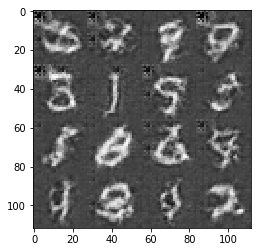

Epoch 2/4... Elapsed 2.62 seconds, Discriminator Loss: 0.4722... Generator Loss: 9.4598
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4068... Generator Loss: 12.2960
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3530... Generator Loss: 5.3876
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.8538... Generator Loss: 1.2523
Epoch 2/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3355... Generator Loss: 5.3080
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3796... Generator Loss: 5.5122
Epoch 2/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3547... Generator Loss: 8.6758
Epoch 3/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3646... Generator Loss: 8.9843
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4953... Generator Loss: 2.2647
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3478... Generator Loss: 5.5971
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3358... Generator Loss: 8.9556
Epoch 3/4... Elapsed 2.32 secon

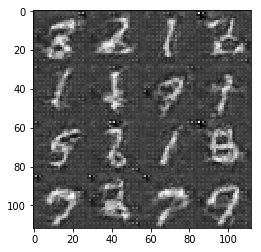

Epoch 3/4... Elapsed 2.62 seconds, Discriminator Loss: 0.3388... Generator Loss: 7.9654
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.5409... Generator Loss: 8.5771
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3477... Generator Loss: 7.5839
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4901... Generator Loss: 2.2014
Epoch 3/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3452... Generator Loss: 4.9515
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4949... Generator Loss: 8.5832
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3645... Generator Loss: 6.1152
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.5512... Generator Loss: 1.8480
Epoch 3/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3377... Generator Loss: 10.4160
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 2.5372... Generator Loss: 0.3257
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3548... Generator Loss: 4.9298
Epoch 3/4... Elapsed 2.32 secon

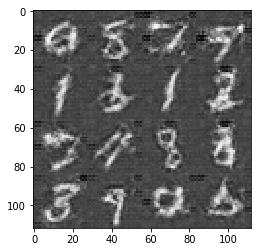

Epoch 3/4... Elapsed 2.62 seconds, Discriminator Loss: 0.3501... Generator Loss: 11.1910
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4344... Generator Loss: 5.6804
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3316... Generator Loss: 6.7077
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3474... Generator Loss: 6.2235
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.5840... Generator Loss: 9.6476
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4313... Generator Loss: 5.6169
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3368... Generator Loss: 5.6972
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3909... Generator Loss: 3.0823
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.8839... Generator Loss: 1.3225
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3461... Generator Loss: 4.5233
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3606... Generator Loss: 5.1087
Epoch 3/4... Elapsed 2.34 secon

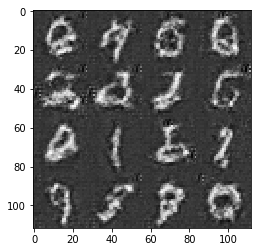

Epoch 3/4... Elapsed 2.72 seconds, Discriminator Loss: 0.5559... Generator Loss: 2.6259
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3957... Generator Loss: 3.0687
Epoch 3/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3301... Generator Loss: 7.5068
Epoch 3/4... Elapsed 2.36 seconds, Discriminator Loss: 1.3677... Generator Loss: 0.5920
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3490... Generator Loss: 4.3627
Epoch 3/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3562... Generator Loss: 5.7362
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3538... Generator Loss: 9.2963
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.9036... Generator Loss: 1.0787
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3349... Generator Loss: 5.9046
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4881... Generator Loss: 4.0791
Epoch 3/4... Elapsed 2.37 seconds, Discriminator Loss: 0.4472... Generator Loss: 9.5830
Epoch 3/4... Elapsed 2.34 second

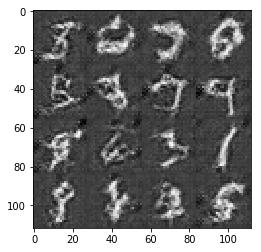

Epoch 3/4... Elapsed 2.64 seconds, Discriminator Loss: 0.3441... Generator Loss: 6.0402
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3406... Generator Loss: 4.6713
Epoch 3/4... Elapsed 2.33 seconds, Discriminator Loss: 0.5380... Generator Loss: 2.5241
Epoch 3/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3518... Generator Loss: 4.4743
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3340... Generator Loss: 6.4883
Epoch 3/4... Elapsed 2.36 seconds, Discriminator Loss: 2.0140... Generator Loss: 9.3769
Epoch 3/4... Elapsed 2.35 seconds, Discriminator Loss: 0.4160... Generator Loss: 2.7146
Epoch 3/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3329... Generator Loss: 7.8221
Epoch 3/4... Elapsed 2.35 seconds, Discriminator Loss: 0.3557... Generator Loss: 9.3850
Epoch 3/4... Elapsed 2.36 seconds, Discriminator Loss: 1.9073... Generator Loss: 6.9509
Epoch 3/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3317... Generator Loss: 6.1887
Epoch 3/4... Elapsed 2.34 second

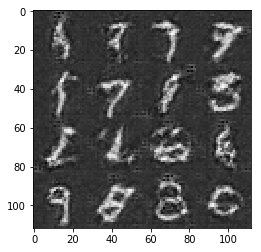

Epoch 3/4... Elapsed 2.62 seconds, Discriminator Loss: 0.3291... Generator Loss: 7.7189
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.5316... Generator Loss: 2.2893
Epoch 4/4... Elapsed 2.36 seconds, Discriminator Loss: 1.8309... Generator Loss: 10.2640
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.4545... Generator Loss: 5.9885
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3300... Generator Loss: 9.8853
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3403... Generator Loss: 4.7566
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3506... Generator Loss: 6.5596
Epoch 4/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3377... Generator Loss: 7.0436
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3403... Generator Loss: 5.0224
Epoch 4/4... Elapsed 2.32 seconds, Discriminator Loss: 0.3366... Generator Loss: 8.8053
Epoch 4/4... Elapsed 2.35 seconds, Discriminator Loss: 0.3905... Generator Loss: 3.2082
Epoch 4/4... Elapsed 2.34 secon

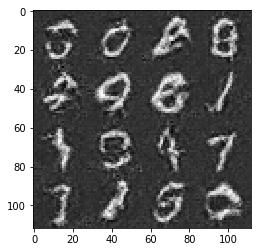

Epoch 4/4... Elapsed 2.64 seconds, Discriminator Loss: 0.4297... Generator Loss: 2.5851
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3663... Generator Loss: 6.8905
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.7731... Generator Loss: 2.0402
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3999... Generator Loss: 3.0121
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3551... Generator Loss: 6.4907
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3555... Generator Loss: 5.6913
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3495... Generator Loss: 5.1890
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3301... Generator Loss: 8.3084
Epoch 4/4... Elapsed 2.36 seconds, Discriminator Loss: 0.8005... Generator Loss: 2.1015
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3352... Generator Loss: 5.4744
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3557... Generator Loss: 4.4110
Epoch 4/4... Elapsed 2.32 second

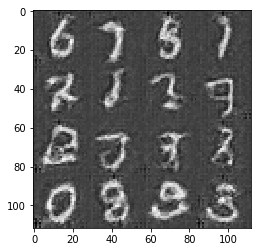

Epoch 4/4... Elapsed 2.64 seconds, Discriminator Loss: 0.3334... Generator Loss: 6.1134
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3467... Generator Loss: 7.2756
Epoch 4/4... Elapsed 2.32 seconds, Discriminator Loss: 2.3285... Generator Loss: 0.2187
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.5806... Generator Loss: 1.6689
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4816... Generator Loss: 2.1329
Epoch 4/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4029... Generator Loss: 2.9508
Epoch 4/4... Elapsed 2.32 seconds, Discriminator Loss: 0.4423... Generator Loss: 8.9328
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4442... Generator Loss: 8.1532
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4138... Generator Loss: 2.8985
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.7925... Generator Loss: 1.4975
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3417... Generator Loss: 4.7078
Epoch 4/4... Elapsed 2.34 second

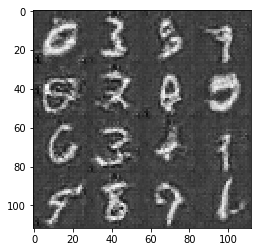

Epoch 4/4... Elapsed 2.64 seconds, Discriminator Loss: 0.3477... Generator Loss: 4.2509
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3547... Generator Loss: 4.4034
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.4549... Generator Loss: 5.3068
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3565... Generator Loss: 7.2855
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3689... Generator Loss: 7.2430
Epoch 4/4... Elapsed 2.36 seconds, Discriminator Loss: 1.0952... Generator Loss: 10.0596
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4701... Generator Loss: 6.0382
Epoch 4/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3312... Generator Loss: 6.9213
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3486... Generator Loss: 9.0169
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 3.9532... Generator Loss: 7.9683
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3348... Generator Loss: 7.1070
Epoch 4/4... Elapsed 2.35 secon

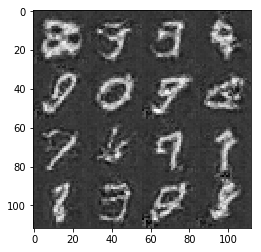

Epoch 4/4... Elapsed 2.66 seconds, Discriminator Loss: 0.3356... Generator Loss: 8.0015
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3565... Generator Loss: 4.3177
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.4265... Generator Loss: 2.7367
Epoch 4/4... Elapsed 2.36 seconds, Discriminator Loss: 0.3460... Generator Loss: 4.4172
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 0.3350... Generator Loss: 6.6979
Epoch 4/4... Elapsed 2.33 seconds, Discriminator Loss: 2.1732... Generator Loss: 9.9056
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3700... Generator Loss: 5.5335
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3671... Generator Loss: 6.8921
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3684... Generator Loss: 4.8107
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.9421... Generator Loss: 12.3799
Epoch 4/4... Elapsed 2.34 seconds, Discriminator Loss: 0.3781... Generator Loss: 3.2739
Epoch 4/4... Elapsed 2.34 secon

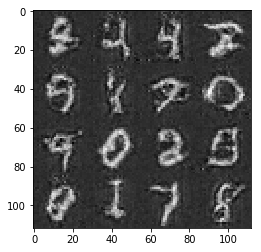

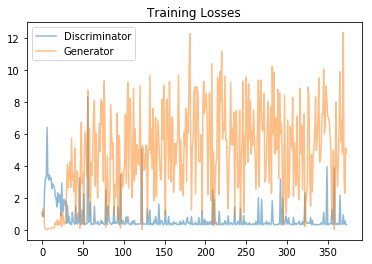

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Elapsed 4.00 seconds, Discriminator Loss: 1.2005... Generator Loss: 1.0346
Epoch 1/1... Elapsed 3.33 seconds, Discriminator Loss: 0.8984... Generator Loss: 1.3482
Epoch 1/1... Elapsed 3.10 seconds, Discriminator Loss: 0.8539... Generator Loss: 1.4689
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.7611... Generator Loss: 1.4438
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.9157... Generator Loss: 1.0989
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.8897... Generator Loss: 1.0498
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.9073... Generator Loss: 0.9866
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 3.4343... Generator Loss: 0.1080
Epoch 1/1... Elapsed 3.10 seconds, Discriminator Loss: 6.5788... Generator Loss: 0.0060
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 6.4474... Generator Loss: 0.0063
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 2.1016... Generator Loss: 0.5015
Epoch 1/1...

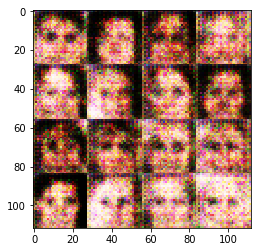

Epoch 1/1... Elapsed 3.38 seconds, Discriminator Loss: 1.5809... Generator Loss: 0.6465
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.4803... Generator Loss: 5.5535
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.3889... Generator Loss: 3.6235
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4615... Generator Loss: 2.5904
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 4.9071... Generator Loss: 0.0320
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4019... Generator Loss: 4.1778
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.5791... Generator Loss: 1.8494
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.8001... Generator Loss: 2.2309
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 1.3054... Generator Loss: 0.8121
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.6950... Generator Loss: 1.8049
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3889... Generator Loss: 4.3086
Epoch 1/1... Elapsed 3.06 second

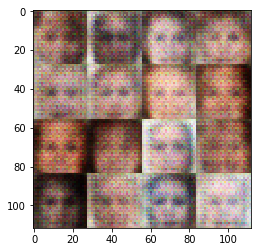

Epoch 1/1... Elapsed 3.37 seconds, Discriminator Loss: 1.7481... Generator Loss: 0.7795
Epoch 1/1... Elapsed 3.11 seconds, Discriminator Loss: 1.4300... Generator Loss: 0.6969
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3355... Generator Loss: 7.2445
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 1.0268... Generator Loss: 11.2496
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3382... Generator Loss: 7.3811
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.4712... Generator Loss: 12.1059
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3351... Generator Loss: 9.9066
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.7213... Generator Loss: 1.2417
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.5663... Generator Loss: 1.8813
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4073... Generator Loss: 4.3317
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4917... Generator Loss: 13.5615
Epoch 1/1... Elapsed 3.07 sec

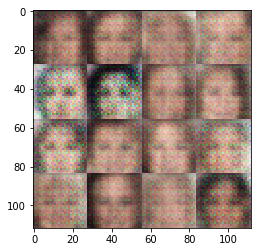

Epoch 1/1... Elapsed 3.37 seconds, Discriminator Loss: 1.5199... Generator Loss: 0.6079
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3438... Generator Loss: 10.7076
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3449... Generator Loss: 6.1500
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.3504... Generator Loss: 5.9117
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3596... Generator Loss: 4.7926
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.6265... Generator Loss: 1.6852
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3526... Generator Loss: 6.9065
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4153... Generator Loss: 2.6701
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3985... Generator Loss: 6.1359
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3597... Generator Loss: 3.8684
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.7340... Generator Loss: 3.3233
Epoch 1/1... Elapsed 3.07 secon

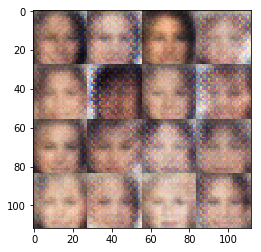

Epoch 1/1... Elapsed 3.37 seconds, Discriminator Loss: 0.3330... Generator Loss: 6.9775
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3825... Generator Loss: 8.8234
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.4473... Generator Loss: 12.6958
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3333... Generator Loss: 6.8995
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3390... Generator Loss: 8.1068
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3352... Generator Loss: 10.6559
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3614... Generator Loss: 8.2387
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3894... Generator Loss: 3.2268
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4212... Generator Loss: 2.5433
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3333... Generator Loss: 7.4520
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3710... Generator Loss: 3.5449
Epoch 1/1... Elapsed 3.07 seco

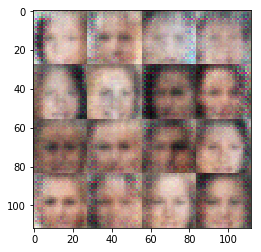

Epoch 1/1... Elapsed 3.38 seconds, Discriminator Loss: 0.3318... Generator Loss: 6.8980
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3371... Generator Loss: 11.2742
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4654... Generator Loss: 2.2838
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.4298... Generator Loss: 10.3116
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4584... Generator Loss: 2.3516
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.5494... Generator Loss: 1.7959
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.5304... Generator Loss: 1.9019
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3309... Generator Loss: 11.4401
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 2.3754... Generator Loss: 12.5669
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.7685... Generator Loss: 1.2800
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3357... Generator Loss: 5.8983
Epoch 1/1... Elapsed 3.03 se

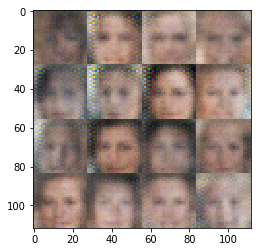

Epoch 1/1... Elapsed 3.36 seconds, Discriminator Loss: 0.3405... Generator Loss: 7.8059
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3952... Generator Loss: 7.1197
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3325... Generator Loss: 11.7938
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3427... Generator Loss: 4.7513
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3406... Generator Loss: 8.4108
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3376... Generator Loss: 9.4179
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3378... Generator Loss: 5.8655
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 1.2274... Generator Loss: 0.5492
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3791... Generator Loss: 9.1915
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3561... Generator Loss: 12.2370
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.8234... Generator Loss: 12.2448
Epoch 1/1... Elapsed 3.09 sec

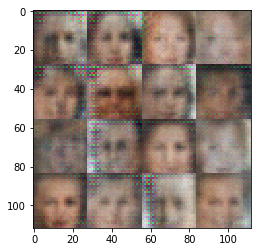

Epoch 1/1... Elapsed 3.35 seconds, Discriminator Loss: 0.3380... Generator Loss: 10.9975
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.5704... Generator Loss: 1.7509
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3548... Generator Loss: 10.1596
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.4948... Generator Loss: 2.9097
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.4284... Generator Loss: 2.9819
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3297... Generator Loss: 10.8531
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.5369... Generator Loss: 1.9195
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3809... Generator Loss: 3.1678
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3385... Generator Loss: 5.4767
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.4161... Generator Loss: 10.0321
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 1.5317... Generator Loss: 14.3516
Epoch 1/1... Elapsed 3.06 s

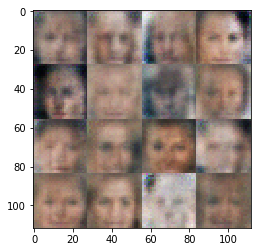

Epoch 1/1... Elapsed 3.36 seconds, Discriminator Loss: 0.3303... Generator Loss: 9.5620
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3334... Generator Loss: 11.7989
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3489... Generator Loss: 8.2044
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.4793... Generator Loss: 10.9594
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 1.4108... Generator Loss: 0.6018
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.4504... Generator Loss: 2.4325
Epoch 1/1... Elapsed 3.03 seconds, Discriminator Loss: 0.3951... Generator Loss: 12.1518
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3550... Generator Loss: 4.0865
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3679... Generator Loss: 8.1394
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 2.4087... Generator Loss: 8.5104
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.5566... Generator Loss: 2.4606
Epoch 1/1... Elapsed 3.06 sec

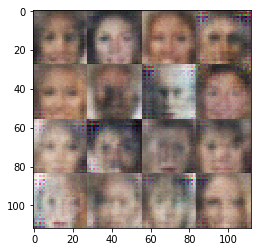

Epoch 1/1... Elapsed 3.37 seconds, Discriminator Loss: 0.3367... Generator Loss: 8.8085
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.7226... Generator Loss: 1.3777
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3759... Generator Loss: 5.3576
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3374... Generator Loss: 6.8226
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3531... Generator Loss: 8.5336
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.4066... Generator Loss: 3.0476
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3311... Generator Loss: 7.4044
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.4750... Generator Loss: 4.8843
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3794... Generator Loss: 11.3309
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3932... Generator Loss: 3.2480
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3365... Generator Loss: 5.5402
Epoch 1/1... Elapsed 3.06 secon

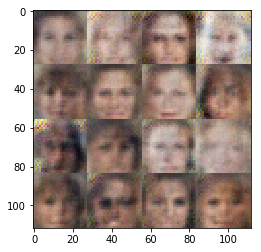

Epoch 1/1... Elapsed 3.45 seconds, Discriminator Loss: 0.3363... Generator Loss: 15.9862
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.3869... Generator Loss: 5.8011
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3523... Generator Loss: 7.0668
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3391... Generator Loss: 7.4049
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3799... Generator Loss: 4.3903
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.4902... Generator Loss: 6.3838
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.6662... Generator Loss: 1.5899
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3581... Generator Loss: 7.6580
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3369... Generator Loss: 6.1976
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3796... Generator Loss: 3.4217
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 1.0526... Generator Loss: 0.8753
Epoch 1/1... Elapsed 3.07 secon

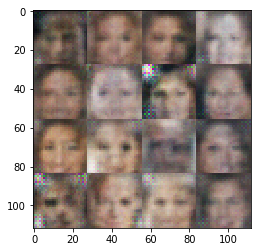

Epoch 1/1... Elapsed 3.36 seconds, Discriminator Loss: 0.4568... Generator Loss: 2.5560
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.5030... Generator Loss: 14.6008
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.6067... Generator Loss: 2.1045
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3446... Generator Loss: 7.4729
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.4424... Generator Loss: 2.6066
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3288... Generator Loss: 10.5598
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.4270... Generator Loss: 9.3857
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4843... Generator Loss: 2.8384
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3354... Generator Loss: 11.1885
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3488... Generator Loss: 4.6111
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.5223... Generator Loss: 6.8157
Epoch 1/1... Elapsed 3.06 sec

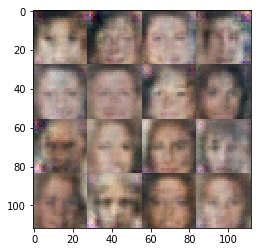

Epoch 1/1... Elapsed 3.38 seconds, Discriminator Loss: 0.3410... Generator Loss: 5.9003
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3512... Generator Loss: 5.2116
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.6205... Generator Loss: 2.4427
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3519... Generator Loss: 8.1511
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3560... Generator Loss: 8.6501
Epoch 1/1... Elapsed 3.09 seconds, Discriminator Loss: 0.4025... Generator Loss: 3.1224
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3521... Generator Loss: 12.0975
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3519... Generator Loss: 11.9828
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 1.2643... Generator Loss: 0.5568
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3343... Generator Loss: 6.4927
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3335... Generator Loss: 8.6808
Epoch 1/1... Elapsed 3.04 seco

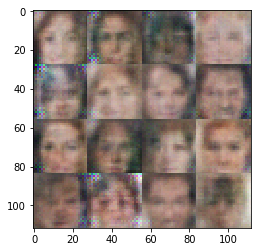

Epoch 1/1... Elapsed 3.37 seconds, Discriminator Loss: 1.5752... Generator Loss: 10.6367
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3310... Generator Loss: 8.6710
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3320... Generator Loss: 6.3376
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3643... Generator Loss: 4.0088
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.4777... Generator Loss: 2.2291
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 1.7308... Generator Loss: 0.3573
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3453... Generator Loss: 5.1017
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3583... Generator Loss: 9.5421
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3342... Generator Loss: 11.4390
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3347... Generator Loss: 7.6245
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.4021... Generator Loss: 3.7313
Epoch 1/1... Elapsed 3.04 seco

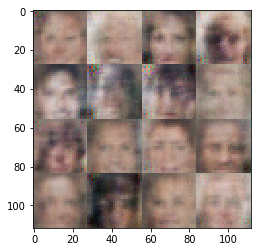

Epoch 1/1... Elapsed 3.40 seconds, Discriminator Loss: 0.3790... Generator Loss: 3.7986
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3393... Generator Loss: 10.8410
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3909... Generator Loss: 11.2400
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4894... Generator Loss: 11.1379
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.5355... Generator Loss: 1.9342
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.5506... Generator Loss: 1.8946
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3778... Generator Loss: 4.0364
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 1.4255... Generator Loss: 7.6871
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3404... Generator Loss: 5.4082
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 1.0636... Generator Loss: 0.8189
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3334... Generator Loss: 7.7727
Epoch 1/1... Elapsed 3.04 sec

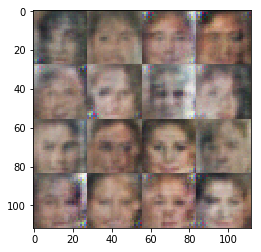

Epoch 1/1... Elapsed 3.40 seconds, Discriminator Loss: 0.3621... Generator Loss: 11.4851
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3351... Generator Loss: 7.5528
Epoch 1/1... Elapsed 3.06 seconds, Discriminator Loss: 0.3936... Generator Loss: 3.4258
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3400... Generator Loss: 5.3968
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.3567... Generator Loss: 12.6698
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3339... Generator Loss: 9.7368
Epoch 1/1... Elapsed 3.08 seconds, Discriminator Loss: 0.3315... Generator Loss: 9.1366
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.3398... Generator Loss: 6.8281
Epoch 1/1... Elapsed 3.07 seconds, Discriminator Loss: 0.4398... Generator Loss: 3.2169
Epoch 1/1... Elapsed 3.05 seconds, Discriminator Loss: 0.4045... Generator Loss: 2.9387
Epoch 1/1... Elapsed 3.04 seconds, Discriminator Loss: 0.3395... Generator Loss: 11.5524
Epoch 1/1... Elapsed 3.07 sec

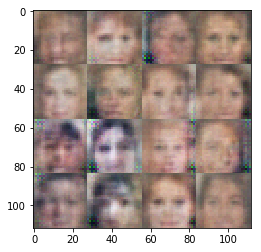

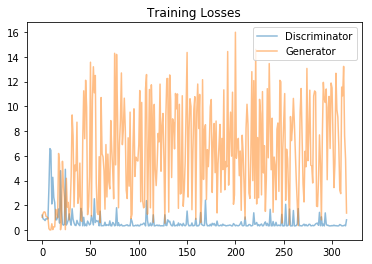

In [13]:
batch_size = 64
z_dim = 300
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.